# Fine‑tuning **Gemma‑3 Instruct (1 B)** on the *MTS‑Dialog* medical‑conversation dataset  

*An end‑to‑end, LoRA‑based workflow with evaluation & demo*  


**Provenance / Credits**

* Originally authored in Google Colab.  
* Refactored and cleaned up for GitHub readability – May 2025.  
* Dataset: **MTS‑Dialog** (© 2024, MIT‑licensed)  
* Model: **Gemma‑3 Instruct 1 B** via `keras‑hub`.  

> The notebook assumes Google Colab **or** a local machine with a modern GPU and official Gemma access.  


In [1]:
%%capture
# ─── Environment setup ────────────────────────────────────────────────────────
# Feel free to skip if these libraries are already installed.
!pip install -q -U keras-hub keras keras-nlp rouge_score scipy tqdm ipywidgets

## 🔑 Reproducibility – set a single global RNG seed

In [ ]:
# Download the utils.py file from the GitHub repository and charge it through Colab
from google.colab import files
uploaded = files.upload()

In [2]:
import os, random, gc, json, textwrap
import numpy as np
import tensorflow as tf

SEED = 42
set_global_seed(SEED)

In [3]:
# ─── Core libraries ──────────────────────────────────────────────────────────
import pprint, itertools, math, time
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy import stats
from rouge_score import rouge_scorer
# import torch

import keras
import keras_hub
import keras_nlp
from keras.callbacks import EarlyStopping

from utils import set_global_seed, estimate_tokens, clear_memory, filter_data_by_length, make_ds, compile_with_sampler, compile_for_training, safe_generate, evaluate_model

# Optional: Colab‑only helper to pull your Kaggle creds from the browser
try:
    from google.colab import userdata  # type: ignore
    os.environ["KAGGLE_USERNAME"] = userdata.get("KAGGLE_USERNAME")
    os.environ["KAGGLE_KEY"] = userdata.get("KAGGLE_KEY")
except (ImportError, ModuleNotFoundError):
    print("Not on Colab – set $KAGGLE_USERNAME and $KAGGLE_KEY manually if needed.")

## 📝 Prompt template (single definition – DRY)

In [4]:
# Using Gemma's native chat format for best performance
TEMPLATE = """<start_of_turn>user

### Instruction:
{instruction}

### Doctor-Patient Dialogue:
{dialogue}
<end_of_turn>

<start_of_turn>assistant
"""

instruction = (
    "You are a clinical documentation assistant. Convert the doctor–patient "
    "conversation below into a concise clinical note. Include only medically "
    "relevant facts (symptoms, diagnoses, medications with dosages, procedures). "
    "Do not add commentary or conclusions."
)

formatted_template = TEMPLATE.format(instruction=instruction, dialogue="{dialogue}")
print(formatted_template)

<start_of_turn>user

### Instruction:
You are a clinical documentation assistant. Convert the doctor–patient conversation below into a concise clinical note. Include only medically relevant facts (symptoms, diagnoses, medications with dosages, procedures). Do not add commentary or conclusions.

### Doctor-Patient Dialogue:
{dialogue}
<end_of_turn>

<start_of_turn>assistant



### 🔍 Quick sanity‑check inference with the *base* Gemma model

In [7]:
clear_memory()

base_model = keras_hub.models.Gemma3CausalLM.from_preset("gemma3_instruct_1b")
compile_with_sampler(base_model)

sample_dialogue = """Doctor: How are you feeling today?
Patient: I'm still having chest pains.
Doctor: Are they sharp or dull?
Patient: More of a crushing pressure right here."""

prompt = TEMPLATE.format(
    instruction=instruction,
    dialogue= sample_dialogue
)

print(base_model.generate(prompt, max_length=1024))

#### 🌐 Download the MTS-Dialog dataset
###### You can skip this step if you already have the datasets

In [8]:
from pathlib import Path
import subprocess, sys, shutil

DATA_REPO = "https://github.com/abachaa/MTS-Dialog.git"
DATA_DIR  = Path("MTS-Dialog") / "Main-Dataset"

if DATA_DIR.exists():
    print(f"✅ Dataset already present at: {DATA_DIR.resolve()}")
else:
    print("📥 Cloning MTS-Dialog repository (shallow)…")
    # --depth 1 keeps clone fast and lightweight
    subprocess.run(["git", "clone", "--depth", "1", DATA_REPO], check=True)

    if not DATA_DIR.exists():
        sys.exit("❌ Dataset download failed - Main-Dataset not found.")

    print(f"✅ Download complete! Data located at: {DATA_DIR.resolve()}")

# Make a handy constant the rest of the notebook can rely on
DATA_PATH = DATA_DIR

## 📚 Load & prepare the *MTS‑Dialog* training set

*MTS‑Dialog* (`1.7 k` doctor–patient conversations with expert summaries).  
Below we:  
1. Fetch or load the CSV  
2. (Optionally) **sample 500 rows** for a quick LoRA demo  
3. Wrap dialogue text in triple quotes to preserve line breaks  
4. Build two parallel lists `prompts` and `responses` expected by `keras‑hub`  


In [9]:
# DATA_PATH = "/content/MTS-Dialog-TrainingSet.csv"  # adjust if running locally


df = pd.read_csv(DATA_PATH / "MTS-Dialog-TrainingSet.csv")
print(f"💾 Loaded dataset with {len(df):,} rows")

# --- speed‑up during experimentation ---
# df = df.sample(n=200, random_state=SEED)  # comment‑out for full training

# --- minimal preprocessing ---
df = df.dropna(subset=["dialogue", "section_text"])

# Remove rows where 'section_text' is very short
df = df.query("section_text.str.len() > 30", engine="python")

# Curly-quote normalisation
df["section_text"] = df["section_text"].str.replace("’", "'", regex=False)
df["dialogue"]      = df["dialogue"].str.replace("’", "'", regex=False)

# Trim whitespace and add end token to 'section_text'
df["section_text"] = df["section_text"].str.strip() + "\n<end_of_turn>"

# Trim whitespace
df["dialogue"] = df["dialogue"].str.strip()
print(f"💾 Number of section texts after trimming and basic preprocessing: {len(df['section_text']):,} rows") # Print after trimming

prompts, responses = [], []
for row in df.itertuples(index=False):
    prompts.append(
        TEMPLATE.format(instruction=instruction, dialogue=row.dialogue)
    )
    responses.append(row.section_text)

# Stage 2: Token-length filtering (after prompt formatting)

prompts, responses = filter_data_by_length(prompts, responses, max_input_tokens=1024)

data = {'prompts': prompts, 'responses': responses}
print(f"✅ Prepared {len(prompts):,} filtered prompt/response pairs")

In [10]:
# ─── 🗂️ Train/val split ➜ tf.data pipeline (memory-light) ──────────────
VAL_FRACTION = 0.10
rng = np.random.default_rng(SEED)

prompts_arr   = np.array(data["prompts"],    dtype=object)
responses_arr = np.array(data["responses"],  dtype=object)

idx        = rng.permutation(len(prompts_arr))
val_size   = int(len(idx) * VAL_FRACTION)
val_idx, train_idx = idx[:val_size], idx[val_size:]

train_data = make_ds(prompts_arr[train_idx], responses_arr[train_idx])
val_data   = make_ds(prompts_arr[val_idx],   responses_arr[val_idx])

print(f"🔹 Train samples: {len(train_idx)}")
print(f"🔹 Val   samples: {len(val_idx)}")

# —— immediately free the big NumPy arrays ——
del prompts_arr, responses_arr, idx, train_idx, val_idx
gc.collect()

🔹 Train samples: 831
🔹 Val   samples: 92


47

## 🔧 LoRA fine‑tuning

> Mixed‑precision (`keras.mixed_precision.set_global_policy('mixed_bfloat16')`)  
> can further reduce memory but is optional.  


✅ Model compiled for training with AdamW optimizer (bias/scale excluded from weight decay)
Epoch 1/8
831/831 ━━━━━━━━━━━━━━━━━━━━ 1175s 1s/step - loss: 0.1345 - sparse_categorical_accuracy: 0.5763 - val_loss: 0.1190 - val_sparse_categorical_accuracy: 0.6002
Epoch 2/8
831/831 ━━━━━━━━━━━━━━━━━━━━ 1119s 1s/step - loss: 0.1198 - sparse_categorical_accuracy: 0.6205 - val_loss: 0.1179 - val_sparse_categorical_accuracy: 0.6078
Epoch 3/8
831/831 ━━━━━━━━━━━━━━━━━━━━ 1075s 1s/step - loss: 0.0939 - sparse_categorical_accuracy: 0.6741 - val_loss: 0.1200 - val_sparse_categorical_accuracy: 0.6018
💾  Saved LoRA adapters to lora_rank4_final.weights.lora.h5


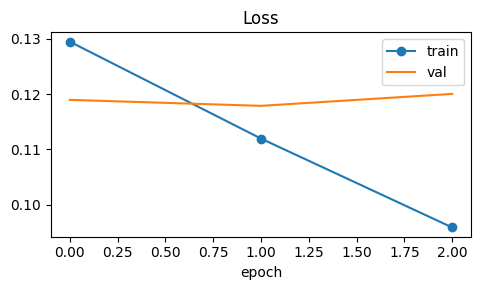

✔️  Fine-tuning complete; memory cleaned.


In [11]:
# 1️⃣  Clean up any leftover models/graphs
clear_memory()

# 2️⃣  Mixed-precision for speed & smaller activations
keras.mixed_precision.set_global_policy("mixed_bfloat16")

# 3️⃣  Load Gemma-1B and enable LoRA
gemma_lm = keras_hub.models.Gemma3CausalLM.from_preset("gemma3_instruct_1b")
gemma_lm.backbone.enable_lora(rank=16)

# train & infer on 1024-token sequences (default was 256)
gemma_lm.preprocessor.sequence_length = 1024

compile_for_training(gemma_lm)

# 4️⃣  Early stopping (no RAM-hungry weight snapshot)
early_stop = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=1, min_delta=1e-3, restore_best_weights=False
)

# Simulate batch_size=4 with gradient accumulation
gradient_accumulation_steps = 4

# 5️⃣  Train
history = gemma_lm.fit(
    train_data,               # tf.data.Dataset from the split cell
    validation_data=val_data,
    epochs=8,                 # feel free to change
    callbacks=[early_stop],
)

# 6️⃣  Save final LoRA adapters (tiny – a few MB)
gemma_lm.backbone.save_lora_weights("lora_rank_16.weights.lora.h5")
print("💾  Saved LoRA adapters to lora_rank_16.weights.lora.h5")

# 7️⃣  Quick loss curve
plt.figure(figsize=(5, 3))
plt.plot(history.history["loss"], "o-", label="train")
plt.plot(history.history.get("val_loss", []), label="val")
plt.title("Loss"); plt.xlabel("epoch"); plt.legend(); plt.tight_layout()
plt.show(); plt.close()

# 8️⃣  Free heavy objects now that we’re done
for obj in ["train_data", "val_data", "history"]:
    if obj in globals():
        del globals()[obj]
gc.collect()

print("✔️  Fine-tuning complete; memory cleaned.")


## 🔬 Validation set evaluation

We compare the *base* and *fine‑tuned* checkpoints on the MTS‑Dialog validation split.  
*(~25 min on a T4, ~8 min on an A100 – feel free to skip in a hurry.)*  


In [13]:
VAL_PATH = DATA_PATH / "MTS-Dialog-ValidationSet.csv"
val_df = pd.read_csv(VAL_PATH)

# Optional speed-up during experimentation
val_df = val_df.sample(n=50, random_state=SEED)

prompts_val, references_val = [], []
for row in val_df.itertuples(index=False):
    prompts_val.append(TEMPLATE.format(instruction=instruction, dialogue=row.dialogue))
    references_val.append(row.section_text)

# Apply same filtering as training data
prompts_val, references_val = filter_data_by_length(
    prompts_val, references_val, max_input_tokens=1024
)

clear_memory()

gemma_lm = keras_hub.models.Gemma3CausalLM.from_preset("gemma3_instruct_1b")
gemma_lm.backbone.enable_lora(rank=16)   # must match the saved rank
gemma_lm.backbone.load_lora_weights("lora_rank_16.weights.lora.h5")

# ---------- 1. Evaluate the fine-tuned model first ----------
fine_outputs, fine_scores, fine_metrics = evaluate_model(
    gemma_lm, prompts_val, references_val, "Fine-tuned"
)

# Free GPU memory held by the tuned checkpoint
del gemma_lm
gc.collect()
tf.keras.backend.clear_session()

# ---------- 2. Evaluate a fresh base model ----------
base_model = keras_hub.models.Gemma3CausalLM.from_preset("gemma3_instruct_1b")
compile_with_sampler(base_model, seed=SEED)

base_outputs, base_scores, base_metrics = evaluate_model(
    base_model, prompts_val, references_val, "Base"
)

# ---------- 3. Summarise the improvements ----------
rows = []
for metric in ["rouge1", "rouge2", "rougeL"]:
    base_vals = base_scores[metric]
    fine_vals = fine_scores[metric]
    delta = np.mean(fine_vals) - np.mean(base_vals)
    t_stat, p_val = stats.ttest_rel(fine_vals, base_vals)
    rows.append((metric.upper(), np.mean(base_vals), np.mean(fine_vals), delta, p_val))

results_df = pd.DataFrame(
    rows, columns=["Metric", "Base", "Fine-tuned", "Δ", "p-value"]
).set_index("Metric")

results_df.style.format("{:.4f}")

📊 Kept 43 / 50 pairs (86.0%)


Generating with Base: 100%|██████████| 43/43 [02:57<00:00,  4.13s/it]


,Base,Fine-tuned,Δ,p-value
Metric,,,,
ROUGE1,0.4018,0.4923,0.0905,0.0005
ROUGE2,0.1769,0.2573,0.0805,0.0004
ROUGEL,0.3330,0.4080,0.0750,0.0013


## 🔄 Quick Interactive Demo

Paste a dialogue below and generate a clinical summary using the fine‑tuned Gemma model.

In [15]:
clear_memory()

tf.keras.backend.clear_session(); gc.collect()
# Load the fine-tuned model with the LoRA-adapted weights
fresh_lm = keras_hub.models.Gemma3CausalLM.from_preset("gemma3_instruct_1b")
fresh_lm.backbone.enable_lora(rank=16)   # must match the saved rank
fresh_lm.backbone.load_lora_weights("lora_rank4_final.weights.lora.h5")
compile_with_sampler(fresh_lm, k=5, seed=SEED)

sample_dialogue = """Doctor: How are you feeling today?
Patient: I'm still having chest pains.
Doctor: Are they sharp or dull?
Patient: More of a crushing pressure right here."""

prompt = TEMPLATE.format(
    instruction=instruction,
    dialogue= sample_dialogue
)

print(safe_generate(fresh_lm, prompt, max_new_tokens=1024))

## 🔧 Further Work

- **Improve Model Performance**: Current results are promising but still limited. Fine-tuning with more epochs, experimenting with learning rates, or trying a higher LoRA rank could yield better summaries.
- **Experiment with Alternatives**: Test other open models like Mistral or LLaMA on the same task. Consider combining LoRA with prompt engineering or instruction tuning.
- **Dataset Enhancements**: Explore data augmentation, add more diverse dialogues, or filter noisy examples to improve generalization.
- **Evaluation Improvements**: Integrate medical-specific metrics (e.g. clinical concept coverage) alongside ROUGE for deeper insight.

🚀 Contributions and experiments are welcome — let’s build a stronger medical summarizer together!